# ***Portada***

Implementación de redes generativas adversarias.

Aprendizaje no supervisado - Visión por computador - Inteligencia artificial

# ***Introducción.***
Una red generativa adversativa es un algoritmo de inteligencia artificial empleado en el área de aprendizaje no supervisado compuesta por un sistema de dos redes neuronales, una red generadora mientras que, una red discriminadora evalúa por medio de la capacidad de discernir entre los datos reales y los generados. El presente trabajo tiene como objetivo principal implementar una red generativa adversativa y entrenarla para que obtenga la capacidad de imágenes de aves. En el presente documento encontrará información sobre la etapa de diseño, implementación, resultados y conclusiones obtenidas del desarrollo de la actividad.

Objetivos:


*   Seleccionar el dataseet y el conjunto de imágenes a tratar para la construcción de la red generativa adversativa.
*   Definir la red generadora y la red discriminadora.
*   Establecer los parámetros de optimización, función de pérdida, el learning rate y el batch size.

# ***Diseño.***

En el presente documento se desarrollo una red generativa adversativa, A continuación, se describe las principales características que se tuvieron en cuenta para su diseño:
Se utilizó el conjunto de datos CIFAR-10, compuesto por 60000 imágenes, divididas en 50000 imágenes para el proceso de entrenamiento y 10000 para el proceso de prueba. Una característica relevante de este conjunto de datos es que contiene 10 clases (aviones, automóviles, aves, gatos, ciervos, perros, ranas, caballos, barcos y camiones). Las imágenes tienen un tamaño de 32 píxeles de ancho y 32 píxeles de alto, en este caso, se utilizará únicamente la clase denominada como aves (birds).

Descripción de la arquitectura de la red.

Para que la red tenga la capacidad de generar imágenes, se utilizarán las siguientes dos redes neuronales:

•	Red generadora: Esta red neuronal en un principio generará ruido, pero con el debido entrenamiento obtendrá la capacidad de generar imágenes, está compuesta por:

Capa de entrada (Densa), ruido con una dimensión igual a 100 y una función de activación “LeakyReLU”.

Capa de configuración (Reshape), toma la salida de la capa Densa.

Capas de convolución transpuesta, se utilizarán tres de estas capas para aumentar las dimensiones de la imagen, se utiliza un kernel 3x3 y un stride de 2. Seguido de cada una de estas capas se utiliza una función de activación “LeakyReLU”.

Capa de salida, esta última capa convolucional tiene una salida de 3 canales (RGB) y utiliza una función de activación tangente hiperbólica.

•	Red discriminadora: Esta red determina si una imagen es real o no y servirá para entrenar la red generadora, está compuesta por:

Cuatro capas ocultas seguidas por funciones de activación “LeakyReLU”.

Una capa de “aplanamiento” Flatten.

Una capa de Dropout.

Por último, una capa Densa como salida de esta red neuronal convolucional.

En cuanto a frameworks se utilizó Tensorflow y Keras, además se utilizó una herramienta nueva que en clases anteriores no se había usado como lo es la herramienta Conv2DTranspose, la cual básicamente se usa en la red generadora para agrandar la imagen a medida que se convoluciona.


# ***Etapa de implementación.***

In [1]:
#Importando las librerías necesarias para desarrollar la actividad.
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

Cargando el dataset.

In [2]:
def load_cifar10_birds():
    (X_train, y_train), (_, _) = cifar10.load_data()
    bird_indices = np.where(y_train == 2)[0]  # el número 2 corresponde a "birds" en CIFAR-10
    X_birds = X_train[bird_indices]
    X_birds = (X_birds.astype('float32') - 127.5) / 127.5
    return X_birds

In [3]:
dataset = load_cifar10_birds()

Red Generadora.

In [4]:
#Definición de la función para la red generadora.
def build_generator():
    generator = Sequential()
    generator.add(Dense(256*4*4, input_shape=(100,)))
    generator.add(LeakyReLU())
    generator.add(Reshape((4, 4, 256)))
    generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2D(3, kernel_size=3, padding="same", activation='tanh'))
    return generator

Red Discriminadora.

In [5]:
#Definición de la función para la red discriminadora
def build_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=3, padding="same", input_shape=(32, 32, 3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Conv2D(128, kernel_size=3, strides=(2,2), padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Conv2D(128, kernel_size=3, strides=(2,2), padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Conv2D(256, kernel_size=3, strides=(2,2), padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator

Generando muestras reales con su repectiva etiqueta.

In [6]:
def generate_real_samples(dataset, n_samples):
    indices = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[indices]
    y = np.ones((n_samples, 1))
    return X, y

Generando puntos de espacio latente como entrada para el generador.

In [7]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

Generando muestras falsas con su respectiva etiqueta.

In [8]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

Definiendo la red generativa adversaría.

In [9]:
#Función para definir la red generativa adversativa.
def define_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = generator.input
    gan_output = discriminator(generator.output)
    gan = Model(gan_input, gan_output)
    optimizador = Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer= optimizador)
    return gan

Definiendo la función para el entrenamiento.

In [10]:
def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs, n_batch):
    batch_per_epoch = dataset.shape[0] // n_batch
    half_batch = n_batch // 2
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, acc_real = discriminator.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            d_loss2, acc_fake = discriminator.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f, Acc Real: %.3f%%, Acc Fake: %.3f%%' %
                  (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss, acc_real*100, acc_fake*100))

Construyendo y compilando la red discriminadora.

In [11]:
discriminator = build_discriminator()
optimizador = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=['accuracy'])

Construyendo la red generadora.

In [12]:
generator = build_generator()

Creando la red generativa adversativa.

In [13]:
gan = define_gan(generator, discriminator)

# ***Resultados***

Resultado del entrenamiento de la red generativa adversativa.

In [14]:
train_gan(generator, discriminator, gan, dataset, latent_dim=100, n_epochs=350, n_batch=128)

Se han truncado las últimas 5000 líneas del flujo de salida.
2/2 [==============================] - 0s 6ms/step
>286, 36/39, d1=0.619, d2=0.506, g=1.212, Acc Real: 60.938%, Acc Fake: 79.688%
2/2 [==============================] - 0s 5ms/step
>286, 37/39, d1=0.534, d2=0.465, g=1.227, Acc Real: 67.188%, Acc Fake: 82.812%
2/2 [==============================] - 0s 5ms/step
>286, 38/39, d1=0.543, d2=0.541, g=1.183, Acc Real: 71.875%, Acc Fake: 76.562%
2/2 [==============================] - 0s 5ms/step
>286, 39/39, d1=0.448, d2=0.482, g=1.201, Acc Real: 73.438%, Acc Fake: 78.125%
2/2 [==============================] - 0s 6ms/step
>287, 1/39, d1=0.516, d2=0.660, g=1.255, Acc Real: 65.625%, Acc Fake: 70.312%
2/2 [==============================] - 0s 8ms/step
>287, 2/39, d1=0.531, d2=0.496, g=1.233, Acc Real: 71.875%, Acc Fake: 76.562%
2/2 [==============================] - 0s 5ms/step
>287, 3/39, d1=0.512, d2=0.627, g=1.195, Acc Real: 71.875%, Acc Fake: 65.625%
2/2 [===========================

Collage de 30 imágenes generadas por la red.

1/1 [==============================] - 0s 384ms/step


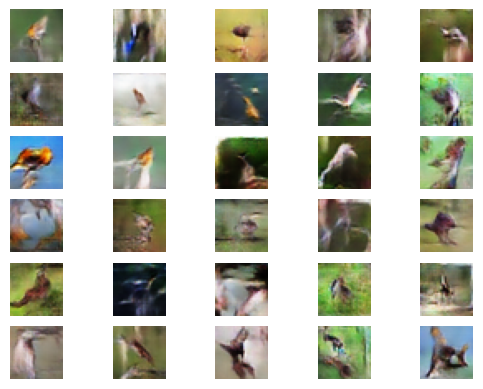

In [15]:
X_fake, _ = generate_fake_samples(generator, latent_dim=100, n_samples=30)
X_fake = (X_fake+1)/2

for i in range(30):
  plt.subplot(6,5,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])

# ***Conclusiones***

El desarrollo de la red generativa adversativa permitió manipular una herramienta nueva, esta herramienta o librería se llama Conv2DTranspose, la cual básicamente se usa en la red generadora para agrandar la imagen a medida que se convoluciona.

El desarrollo del presente trabajo permitió comprender de mejor forma la composición de una red generativa adversativa, la cual basicamente se compone de una red generadora y una red discriminadora, en la que se observó que la arquitectura y composición de la discriminadora es una red neuronal convolucional que utiliza "Conv2D" para su construcción, mientras que, la red generadora utiliza "Conv2DTranspose" para la construcción de sus capas.

Tras la realización de la actividad y de llevar a cabo diversas pruebas se estableció como parámetro optimizador Adam, la función de pérdida "binary_crossentropy", un valor de learning rate igual a 0.0002 y un valor de batch size igual a 128 y un número total de épocas igual a 350.

La aplicabilidad de este tipo de red en el ámbito del desempeño profesional en mi caso como ingeniero electrónico, se presenta como una herramienta de la inteligencia artificial para abordar problemáticas donde es difícil obtener datos reales o son insuficientes, siendo una solución para entrenar modelos de aprendizaje automático en aplicaciones como lo pueden ser los sistemas de detección de objetos y reconocimiento de señales.

# ***Referencias***

1.   CIFAR-10 and CIFAR-100 datasets. (s/f). Toronto.edu. Recuperado el 10 de marzo de 2024, de https://www.cs.toronto.edu/~kriz/cifar.html

2.   Jauregui, A. F. (2020, julio 13). Cómo crear una Red Generativa Antagónica (GAN) en Python. Ander Fernández; Ander Fernández Jauregui. https://anderfernandez.com/blog/como-crear-una-red-generativa-antagonica-gan-en-python/

3.   Wikipedia contributors. (s/f). Red generativa adversativa. Wikipedia, The Free Encyclopedia. https://es.wikipedia.org/w/index.php?title=Red_generativa_adversativa&oldid=152476624





